<a href="https://colab.research.google.com/github/Kimuramoro/EnvDatSci/blob/main/PAGU24.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [36]:
import pandas as pd
import geopandas as gpd
from shapely.geometry import Point
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import networkx as nx
import matplotlib as mpl
from community import community_louvain
from scipy.stats import pearsonr
from scipy.stats import spearmanr
from google.colab import files

#https://gis.dep.pa.gov/macroviewer/index.html
stations = pd.read_excel('/content/Macroinvertebrate_Data.xlsx', sheet_name='Stations')
freestone = stations[stations['METHOD'] == 'Freestone']  #only freestone streams

taxa = pd.read_excel('/content/Macroinvertebrate_Data.xlsx', sheet_name='Taxa')

#geeodataframe point for spatial joining
freestone = freestone.copy()
freestone.loc[:, 'geometry'] = freestone.apply(lambda row: Point(row['LONG'], row['LAT']), axis=1)
freestone_gdf = gpd.GeoDataFrame(freestone, geometry='geometry', crs="epsg:4326")


#https://newdata-dcnr.opendata.arcgis.com/datasets/731205648bb747d396c8920fcdfea4a8/explore
pa_physio_gdf = gpd.read_file("/content/Physiographic_Sections_of_Pennsylvania.zip")

#https://www.dep.pa.gov/DataandTools/Reports/Oil%20and%20Gas%20Reports/Pages/default.aspx
#downloaded last: 7/1/2024
spud = pd.read_csv('/content/Spud_External_Data.csv')

spud = spud.copy()
spud['LATITUDE'] = pd.to_numeric(spud['LATITUDE'], errors='coerce')
spud['LONGITUDE'] = pd.to_numeric(spud['LONGITUDE'], errors='coerce')
spud.loc[:, 'geometry'] = spud.apply(lambda row: Point(row['LONGITUDE'], row['LATITUDE']), axis=1)
spud_gdf = gpd.GeoDataFrame(spud, geometry='geometry', crs="EPSG:4326")
spud_gdf['SPUD_DATE'] = pd.to_datetime(
    spud_gdf['SPUD_DATE']).dt.strftime('%d-%m-%Y')

active_spud = spud_gdf[spud_gdf['WELL_STATUS'] == 'Active']
#gdf points for spatial joining and also had to convert to standardized crs


In [28]:
#geodataframe point for spatial joining
freestone.loc[:,'geometry'] = freestone.apply(lambda row: Point(row['LONG'], row['LAT']), axis=1)
freestone_gdf = gpd.GeoDataFrame(freestone, geometry='geometry', crs="epsg:4326")

pa_physio_gdf = gpd.read_file("/content/Physiographic_Sections_of_Pennsylvania.zip")
physio_stations = gpd.sjoin(freestone_gdf, pa_physio_gdf, how="inner", predicate ="within")
#says what physiographic region each sampling station is in

plateau_stations = physio_stations[physio_stations['PROVINCE'].isin(['Central Lowlands', 'Appalachian Plateaus'])]

plateau_stations = plateau_stations.copy()
plateau_stations.loc[:, 'SAMPLE_DATE'] = pd.to_datetime(
    plateau_stations[['YEAR', 'MONTH', 'DAY']]
).dt.strftime('%d-%m-%Y')

plateau_stations = plateau_stations[['STATIONID', 'HUC8', 'HUC12', 'METHOD_DES', 'SmallFrees', 'LargeFrees', 'geometry', 'SAMPLE_DATE']]
plateau_stations = plateau_stations.drop_duplicates(subset=['STATIONID']).to_crs(epsg=26918)

large_river_stations = plateau_stations.dropna(subset=['LargeFrees'])
small_river_stations = plateau_stations.dropna(subset=['SmallFrees'])


In [29]:
print(f'Stations for small streams: {small_river_stations.shape[0]}')
print(f'Stations for large streams: {large_river_stations.shape[0]}')

Stations for small streams: 6398
Stations for large streams: 2453


In [37]:
def get_well_counts(stations, wells, buffer_distances=[1000, 3000], date_station='SAMPLE_DATE', date_well='SPUD_DATE', well_type='Unconventional'):
    for distance in buffer_distances:
        buffer_col = f'BUFFER_{distance // 1000}km'
        num_wells_col = f'num_{well_type[0]}_{distance // 1000}km'  # Number of wells in the buffer column
        wells_within_col = f'{well_type[0]}_{distance // 1000}km_bool'  # Boolean column for wells within buffer

        stations[buffer_col] = stations.geometry.buffer(distance)
        stations = stations.set_geometry(buffer_col)

        wells_filtered = wells[(wells['WELL_STATUS'] == 'Active') & (wells['UNCONVENTIONAL'] == well_type)]
        wells_filtered = wells_filtered.to_crs(epsg=26918)
        wells_filtered = wells_filtered[['SPUD_DATE', 'API', 'geometry']]

        wells_in_buffer = gpd.sjoin(wells_filtered, stations[[buffer_col, date_station]], predicate='within')
        wells_in_buffer = wells_in_buffer[wells_in_buffer[date_well] <= wells_in_buffer[date_station]]

        well_counts = wells_in_buffer.groupby('index_right').size()
        stations[num_wells_col] = stations.index.map(well_counts).fillna(0).astype(int)

        stations[wells_within_col] = stations[num_wells_col] > 0

    return stations

small_river_stations_with_wells = get_well_counts(small_river_stations,active_spud, well_type='Unconventional')
small_river_stations_with_wells = get_well_counts(small_river_stations_with_wells,active_spud, well_type='Conventional')

#ap_stations = ap_stations.drop(columns = ['BUFFER_1km','BUFFER_3km'], axis=1)


/usr/local/lib/python3.10/dist-packages/geopandas/geodataframe.py:1819: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


In [71]:
def get_closest_well_distance(stations, wells, well_type):

    wells_filtered = wells[wells['UNCONVENTIONAL'] == well_type]

    stations = stations.set_geometry("geometry")
    wells_filtered = wells_filtered.to_crs(stations.crs)

    closest_distances = []

    for _, station in stations.iterrows():

        valid_wells = wells_filtered[wells_filtered['SPUD_DATE'] <= station['SAMPLE_DATE']]

        if valid_wells.empty:
            closest_distances.append(None)
        else:

            distances = valid_wells.geometry.distance(station.geometry)
            closest_distances.append(distances.min())

    stations[f'{well_type[0]}_closest_well_distance'] = closest_distances

    return stations

small_river_stations_with_wells = get_closest_well_distance(small_river_stations_with_wells, active_spud, well_type='Unconventional')

small_river_stations_with_wells = get_closest_well_distance(small_river_stations_with_wells, active_spud, well_type='Conventional')

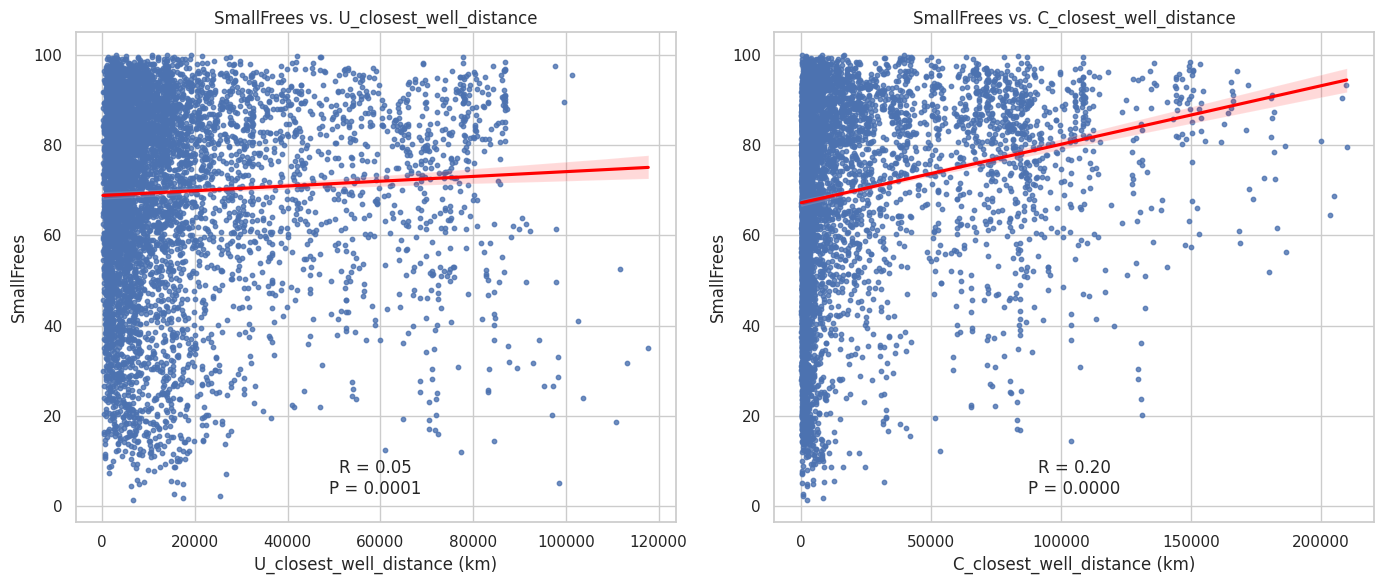

In [86]:
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import linregress

sns.set(style="whitegrid")

fig, axes = plt.subplots(1, 2, figsize=(14, 6))

#scatter plot for U_closest_well_distance vs SmallFrees
sns.regplot(x='U_closest_well_distance', y='SmallFrees', data=small_river_stations_with_wells, ax=axes[0],
            scatter_kws={'s': 10}, line_kws={'color': 'red'})
axes[0].set_title('SmallFrees vs. U_closest_well_distance')
axes[0].set_xlabel('U_closest_well_distance (km)')
axes[0].set_ylabel('SmallFrees')

slope_u, intercept_u, r_value_u, p_value_u, _ = linregress(small_river_stations_with_wells['U_closest_well_distance'],
                                                           small_river_stations_with_wells['SmallFrees'])

axes[0].text(0.5, 0.05, f'R = {r_value_u:.2f}\nP = {p_value_u:.4f}', transform=axes[0].transAxes,
             fontsize=12, ha='center', verticalalignment='bottom')

sns.regplot(x='C_closest_well_distance', y='SmallFrees', data=small_river_stations_with_wells, ax=axes[1],
            scatter_kws={'s': 10}, line_kws={'color': 'red'})
axes[1].set_title('SmallFrees vs. C_closest_well_distance')
axes[1].set_xlabel('C_closest_well_distance (km)')
axes[1].set_ylabel('SmallFrees')


slope_c, intercept_c, r_value_c, p_value_c, _ = linregress(small_river_stations_with_wells['C_closest_well_distance'],
                                                           small_river_stations_with_wells['SmallFrees'])

axes[1].text(0.5, 0.05, f'R = {r_value_c:.2f}\nP = {p_value_c:.4f}', transform=axes[1].transAxes,
             fontsize=12, ha='center', verticalalignment='bottom')

plt.tight_layout()
plt.show()



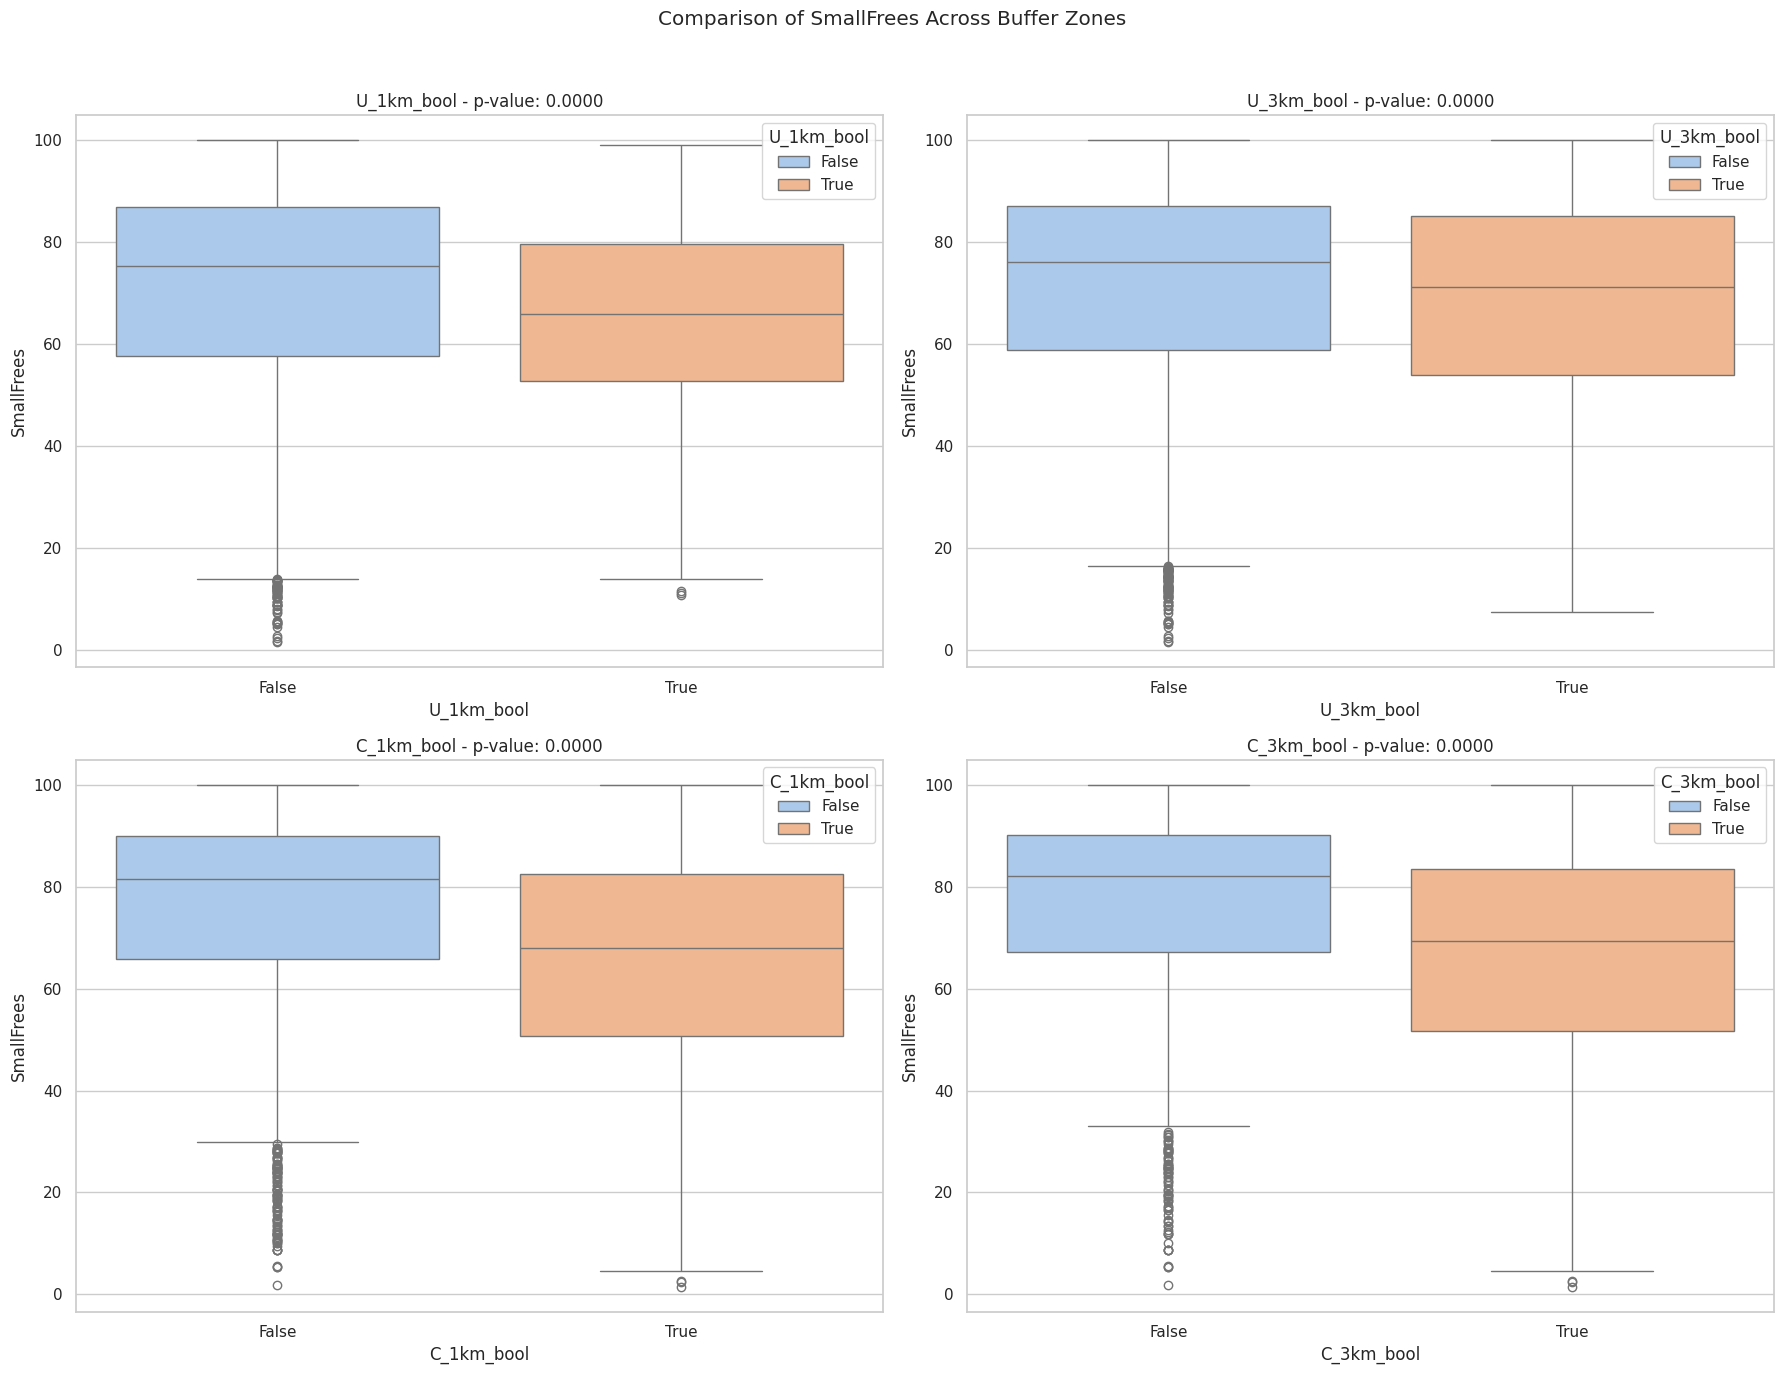

In [88]:
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import mannwhitneyu

def boxplot_multi(ap_stations, column_name):

    bool_columns = ['U_1km_bool', 'U_3km_bool', 'C_1km_bool', 'C_3km_bool']

    plt.figure(figsize=(18, 14))
    sns.set(style="whitegrid")

    for i, col in enumerate(bool_columns, 1):

        group_1 = ap_stations[ap_stations[col] == False][column_name].dropna()
        group_2 = ap_stations[ap_stations[col] == True][column_name].dropna()

        if not group_1.empty and not group_2.empty:
            stat, p_value = mannwhitneyu(group_1, group_2, alternative='two-sided')
        else:
            p_value = None

        plt.subplot(2, 2, i)
        sns.boxplot(x=ap_stations[col], y=ap_stations[column_name], palette="pastel", hue = ap_stations[col])
        plt.title(f'{col} - p-value: {p_value:.4f}' if p_value is not None else f'{col} - Insufficient Data')
        plt.xlabel(col)
        plt.ylabel(column_name)

    plt.suptitle(f'Comparison of {column_name} Across Buffer Zones')
    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.show()

boxplot_multi(small_river_stations_with_wells, 'SmallFrees')


In [72]:
# Get the value counts for each boolean column
u_1km_counts = small_river_stations_with_wells['U_1km_bool'].value_counts()
u_3km_counts = small_river_stations_with_wells['U_3km_bool'].value_counts()
c_1km_counts = small_river_stations_with_wells['C_1km_bool'].value_counts()
c_3km_counts = small_river_stations_with_wells['C_3km_bool'].value_counts()

# Display the counts for each
print("Unconventional Wells within 1km:")
print(u_1km_counts)

print("\nUnconventional Wells within 3km:")
print(u_3km_counts)

print("\nConventional Wells within 1km:")
print(c_1km_counts)

print("\nConventional Wells within 3km:")
print(c_3km_counts)


Unconventional Wells within 1km:
U_1km_bool
False    6078
True      320
Name: count, dtype: int64

Unconventional Wells within 3km:
U_3km_bool
False    4637
True     1761
Name: count, dtype: int64

Conventional Wells within 1km:
C_1km_bool
True     3538
False    2860
Name: count, dtype: int64

Conventional Wells within 3km:
C_3km_bool
True     4013
False    2385
Name: count, dtype: int64


In [80]:
small = small_river_stations_with_wells.copy()
print(small.HUC8.nunique())
print(small.HUC8.value_counts())



50
HUC8
5010003      646
5010001      470
2050205      460
5010005      428
5020006      335
2040104      320
5020005      310
2050202      298
5010006      262
2050106      251
2050203      240
2050206      216
2050201      212
2040103      205
4120101      186
5010007      179
2050104      179
2040101      151
5010004      149
2050101      122
5030106      111
5010009       85
5030101       70
5010008       63
2040106       60
5030102       58
2050107       44
2050204       38
5020004       38
5030105       36
2050302       28
2050303       27
2070002       26
5010002       25
4130002       23
2050103       16
303000105      4
2050105        4
7000105        3
5001420        3
104000325      3
103000281      3
5030103        2
2000186        2
101000033      2
5030104        1
101000087      1
101000160      1
5000238        1
202002255      1
Name: count, dtype: int64


In [89]:
taxa_count = taxa.groupby('STATIONID')['Taxa ID'].nunique().reset_index()
taxa_count.columns = ['STATIONID', 'nTaxa']

taxa = taxa.merge(taxa_count, on='STATIONID', how='left')

<Axes: >

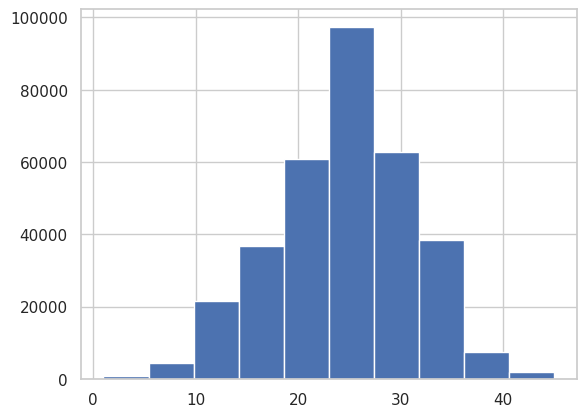

In [90]:
taxa.nTaxa.hist()

In [133]:
taxa = taxa.copy()
station_features = small[['STATIONID', 'HUC8','SmallFrees','U_1km_bool','U_3km_bool','C_1km_bool','C_3km_bool','U_closest_well_distance','C_closest_well_distance']]

taxa_w_station_features = taxa.merge(station_features, on='STATIONID', how='left')

taxa_w_station_features = taxa_w_station_features.dropna(subset=['HUC8'])

In [134]:
taxa_w_station_features['U_DISTquintiles'] = pd.cut(taxa_w_station_features['U_closest_well_distance'],
                                               bins=pd.qcut(taxa_w_station_features['U_closest_well_distance'], 5, retbins=True)[1],
                                               labels=False,
                                               include_lowest=True)

taxa_w_station_features['C_DISTquintiles'] = pd.cut(taxa_w_station_features['C_closest_well_distance'],
                                               bins=pd.qcut(taxa_w_station_features['C_closest_well_distance'], 5, retbins=True)[1],
                                               labels=False,
                                               include_lowest=True)


In [140]:
taxa_w_station_features = taxa_w_station_features.map(lambda x: 1 if x is True else (0 if x is False else x))

taxa_w_station_features['U_closest_well_distance'] = taxa_w_station_features['U_closest_well_distance'] / 1000
taxa_w_station_features['C_closest_well_distance'] = taxa_w_station_features['C_closest_well_distance'] / 1000


In [144]:
taxa_w_station_features.shape

(149536, 14)

<Axes: >

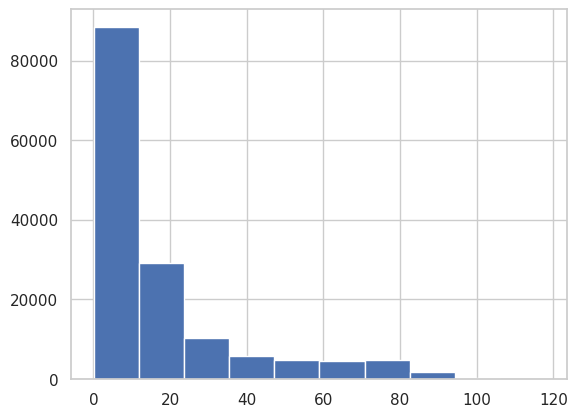

In [141]:
taxa_w_station_features.U_closest_well_distance.hist()

<Axes: >

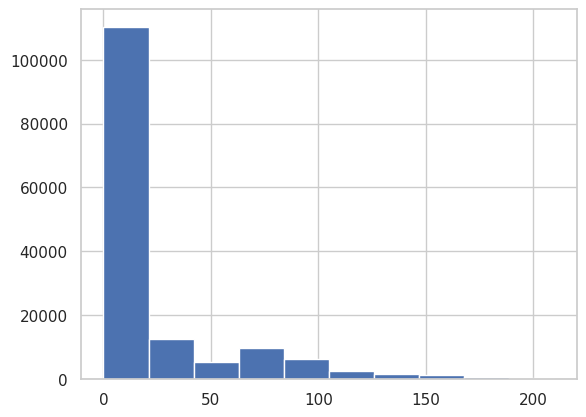

In [142]:
taxa_w_station_features.C_closest_well_distance.hist()

<Axes: >

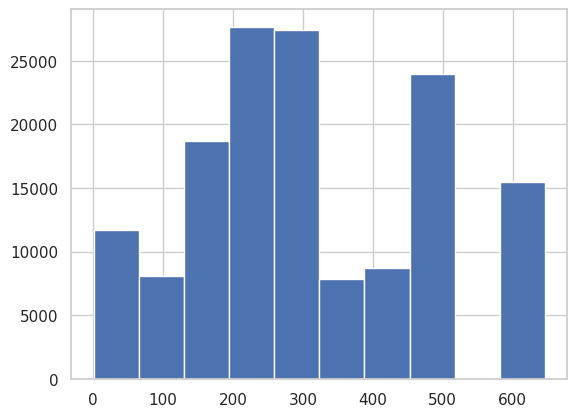

In [147]:
station_count_per_huc = taxa_w_station_features[['STATIONID', 'HUC8']].drop_duplicates()
station_count_per_huc = station_count_per_huc.groupby('HUC8')['STATIONID'].nunique().reset_index(name='NStations')
taxa_w_station_features = taxa_w_station_features.merge(station_count_per_huc, on='HUC8', how='left')

taxa_w_station_features.NStations.hist()

In [148]:
taxa_w_station_features.head()

,STATIONID,Taxa ID,Count,nTaxa,HUC8,SmallFrees,U_1km_bool,U_3km_bool,C_1km_bool,C_3km_bool,U_closest_well_distance,C_closest_well_distance,U_DISTquintiles,C_DISTquintiles,NStations
0,19991017-1911-josecocco,Tipula,4.0,12,2050201.0,28.4448,0,0,1,1,14.288214,3.817263,3,2,212
1,19991017-1911-josecocco,Hydropsyche,4.0,12,2050201.0,28.4448,0,0,1,1,14.288214,3.817263,3,2,212
2,19991017-1911-josecocco,Clitellata,1.0,12,2050201.0,28.4448,0,0,1,1,14.288214,3.817263,3,2,212
3,19991017-1911-josecocco,Chironomidae,150.0,12,2050201.0,28.4448,0,0,1,1,14.288214,3.817263,3,2,212
4,19991017-1911-josecocco,Hyalella,1.0,12,2050201.0,28.4448,0,0,1,1,14.288214,3.817263,3,2,212


In [150]:
preprocessed_data = taxa_w_station_features.copy()
from google.colab import files

preprocessed_data.to_csv('AGU24_preprocessed_data', index=False)

#this is the finished preprocessed code that is ready for statistical analysis. each row is the count of a particular taxa
#at the station it was sampled at. There is also the related station data that will be used as the independent variables, such
#as a 1/0 for the prescence of unconventional/conventional wells within 1 and 3km, as well as the distance to the nearest well.
#It also has the info to be used for subsampled when doing the stats. This include HUC8 watershed it falls within, quartile for distance
#to the nearest well, and the number of stations within each watershed (not considering if less then 15). finally the ibi score for each
#station is preserved so that the network metrics (computed by usig stats toapproximate regional scale relationships from local observations)
#can be used as independent variables to predict the IBI score, an excepted metric to assess health of a particular river. If the network metrics
#strongly related to river health then it gives more significance to a potentional finding that proximity to oil/gas is affecting network metrics

#the stats will all be done in R
